## Introduction

This project is based off data of 3867 annotated bacterial genomes with their corresponding genes in the form of COG ids, provided by Levy et. al. By clustering these genomes together based on taxonomic similarity, we hope to obtain groups of highly-related bacteria. Of these, we are interested in plant-associated bacteria which may be responsible for symbiotic relationships with plants, namely agricultural crops. By obtaining the genes unique to these plant-associated bacteria, we identify genes of interest that may be responsible for the formation of bacterial natural products that defer advantages for agricultural crops in the form of pest resistance, without the need for commercial pesticides.


In [ ]:
# Import block
import umap
import umap.plot
import numpy as np
import pandas as pd
import hdbscan
import bokeh

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold

### Featurisation 
The file containing all the COG ids is formatted such that each line contains 2 important fields: the 
IMG id (corresponding to a certain bacterial genome), and the COG ID, a single gene in that matrix. In order to featurize all our COG IDs, we create a function that returns all the unique genomes (IMG ids) and genes (COG IDs) by parsing the COGfile.

In [220]:
# Constants/filenames
gene_index = 4
genome_index = 1
cogfile = '/home/ana/wet_lab_common/project-plant-genes/cogs.txt'

def genomes_genes(file, genome_index, gene_index):
    unique_genomes = []
    unique_genes = []
    with open(file, 'r+') as fh:
        
        for line in fh.readlines()[1:]:
            if line.split()[genome_index] not in unique_genomes:
                unique_genomes.append(line.split()[genome_index])
            if line.split()[gene_index] not in unique_genes:
                unique_genes.append(line.split()[gene_index])
    return [unique_genomes, unique_genes]
allgenomes, allgenes = genomes_genes(cogfile, genome_index, gene_index)

We then construct a Pandas dataframe of zeros where the indices consist of the genomes, and the column names consist of each gene. By parsing the COGfile a second time, one can read each genome annotation line by line. Concurrently, one  annotates the matrix with 1s for the entry represented by each line, taking the IMG id as the index, and the COG id as the column index. By this process, a feature matrix showing all bacterial genomes, with the presence or absence of all unique genes as “features”, is created. 

In [ ]:
def matrix(file, genes, genomes, gene_col, genome_col):
    gcols = pd.Index(genes, name = "genes")
    grows = pd.Index(genomes, name = "genomes")
    df = pd.DataFrame(data = np.zeros(shape = (len(genomes), len(genes))), index = grows, columns = gcols)
    fh = open(file, 'r+')
    for line in fh.readlines()[1:]:       
        genome = line.split()[genome_index]
        gene = line.split()[gene_index]
        # mark gene as present
        df.at[genome, gene] = 1
    fh.close()
    return df
feature_matrix = matrix(cogfile, allgenes, allgenomes, gene_index, genome_index)
feature_matrix['taxon'] = [0] * len(feature_matrix)
print(feature_matrix.head(10))
print(len(feature_matrix))

Next, one must parse the metadata in order to obtain the taxonomy, association (plant, nonplant, soil), and isolation site of each bacteria. The metadata comes in the form of a TSV with 1 line for each genome. It is read line by line, and a secondary matrix is created concurrently with the columns ‘taxon’, ‘association’, and ‘site’, indexed by each genome ID.


In [207]:
import csv
with open("/home/ana/wet_lab_common/project-plant-genes/metadata_3837_genomes_june2016_complete.tsv") as tsvfile:
    reader = csv.DictReader(tsvfile, dialect = 'excel-tab')
    feature_matrix['site'] = [0] * len(feature_matrix)
    feature_matrix['Classification'] = [0] * len(feature_matrix)
    for ind, row in enumerate(reader):
        #if ind > 20: 
        #    break
        genome_id = row['taxon_oid']
        site = row['Isolation_Site']
        association = row['Classification']
        if genome_id in feature_matrix.index:
            # convert the OD to a taxon
            taxon = list(row.values())[4:-1]
            feature_matrix['taxon'] = feature_matrix['taxon'].astype(object)
            feature_matrix.at[genome_id, 'taxon'] = taxon
            feature_matrix['site'] = feature_matrix['site'].astype(object)
            feature_matrix.at[genome_id, 'site'] = site
            feature_matrix['Classification'] = feature_matrix['Classification'].astype(object)
            feature_matrix.at[genome_id, 'Classification'] = association
print(feature_matrix.head())

genes       COG1522  COG0859  COG0483  COG1066  COG0034  COG2217  COG0101  \
genomes                                                                     
2505679030      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
651053067       1.0      0.0      1.0      1.0      1.0      1.0      1.0   
637000240       1.0      1.0      1.0      1.0      1.0      1.0      1.0   
637000208       1.0      1.0      1.0      1.0      1.0      1.0      1.0   
650716076       1.0      1.0      1.0      1.0      1.0      1.0      1.0   

genes       COG0548  COG0642  COG1032  ...  COG1148  COG3054  COG1153  \
genomes                                ...                              
2505679030      1.0      1.0      0.0  ...      0.0      0.0      0.0   
651053067       1.0      1.0      1.0  ...      0.0      0.0      0.0   
637000240       1.0      1.0      1.0  ...      0.0      0.0      0.0   
637000208       1.0      1.0      1.0  ...      0.0      0.0      0.0   
650716076       1.0   

Next, we create a function to define the genomic similarity between 2 bacterial genomes. This will be important in validating the distance between points in our clusters. This function takes in 2 genome IDs, a reference and a test. It searches the second matrix for the taxa of each genome, and finds the difference between the 2 taxa based on a Bray-Curtis similarity metric (0 means completely dissimilar, 1 means identical).

In [208]:
def genomicdistance(genome_id, reference_id):
# Recursive algorithm which checks for similarity
    def matching(taxon_1, taxon_2):
        
        if len(taxon_1) < 1 or len(taxon_2) < 1:
            return 0
        if taxon_1[0] == taxon_2[0]:
            return 1 + matching(taxon_1[1:], taxon_2[1:])
        else: 
            return 0
    taxon_1 = feature_matrix.at[reference_id,'taxon']
    taxon_2 = feature_matrix.at[genome_id, 'taxon']
    if len(taxon_1) > len(taxon_2):
        return matching(taxon_1, taxon_2) / len(taxon_1)
    else:
        return matching(taxon_1, taxon_2) / len(taxon_2)

Creating a dataframe of the distances:

In [222]:
for genome, row in feature_matrix.iterrows():
    distance = genomicdistance(genome, '2505679030')
    feature_matrix.at[genome, 'distance'] = distance
print(feature_matrix.iloc[450:500,-1])

genomes
2576861342    0.000000
2576861384    0.000000
2576861345    0.000000
2576861346    0.000000
2576861348    0.000000
2576861349    0.000000
2576861368    0.000000
2576861352    0.000000
2576861377    0.000000
2576861424    0.000000
2576861435    0.000000
2576861471    0.000000
2576861456    0.833333
2576861478    0.000000
2576861425    0.000000
2576861498    0.333333
2576861499    0.333333
2576861554    0.333333
640427122     0.000000
2576861487    0.000000
2576861488    0.000000
2576861656    0.000000
2576861677    0.000000
2576861679    0.000000
2576861765    0.000000
2576861768    0.000000
2576861772    0.000000
2576861745    0.000000
2576861748    0.000000
2576861752    0.000000
2576861754    0.000000
2576861755    0.000000
2576861758    0.000000
2576861779    0.000000
2576861725    0.000000
2576861726    0.000000
2576861707    0.000000
2576861731    0.000000
2576861732    0.000000
2576861737    0.000000
2576861669    0.000000
2576861740    0.000000
2571042112    0.000000
257

In [210]:
print(feature_matrix.head())

genes       COG1522  COG0859  COG0483  COG1066  COG0034  COG2217  COG0101  \
genomes                                                                     
2505679030      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
651053067       1.0      0.0      1.0      1.0      1.0      1.0      1.0   
637000240       1.0      1.0      1.0      1.0      1.0      1.0      1.0   
637000208       1.0      1.0      1.0      1.0      1.0      1.0      1.0   
650716076       1.0      1.0      1.0      1.0      1.0      1.0      1.0   

genes       COG0548  COG0642  COG1032  ...  COG3054  COG1153  COG4071  \
genomes                                ...                              
2505679030      1.0      1.0      0.0  ...      0.0      0.0      0.0   
651053067       1.0      1.0      1.0  ...      0.0      0.0      0.0   
637000240       1.0      1.0      1.0  ...      0.0      0.0      0.0   
637000208       1.0      1.0      1.0  ...      0.0      0.0      0.0   
650716076       1.0   


Having finished our preprocessing, we move on to perform feature selection on our dataset in order to remove genes that are not indicative of taxonomic differences. In other words, core metabolic genes that may be shared among all bacteria. Using scikit-learn’s VarianceThreshold, we take our feature matrix and remove from it any genes (‘features’) which have a variance less than 0.1


In [223]:
# Import feature selection package
from sklearn.feature_selection import VarianceThreshold

In [224]:

# split feature matrix into features and target
X = feature_matrix.iloc[:, 0:-4]

#print(distance)
print("Originally had ", str(len(X.columns)), ' features')

# remove features with low variance, aka features with low correlation to a microbe's function/taxonomy
selector = VarianceThreshold(threshold=(.1)).fit(X)

# selecting only most salient features,alternatively could use df.drop()
vdf = feature_matrix[feature_matrix.columns[selector.get_support(indices=True)]]

#print('V-based reduced feature matrix with ', str(len(vdf.columns)), 'features: \n', list(vdf.columns))
#print('\n from ', str(len(vdf)), ' genomes')

# update the target
distance = feature_matrix.loc[list(vdf.index), 'distance']
print(distance)
site = feature_matrix.loc[list(vdf.index), 'site']
taxon = feature_matrix.loc[list(vdf.index), 'taxon']
association = feature_matrix.loc[list(vdf.index), 'Classification']
vdf['association'] =association
vdf.to_pickle('feature_matrix.pkl')
X = vdf
print(X)

Originally had  4211  features
genomes
2505679030    1.0
651053067     0.0
637000240     0.0
637000208     0.0
650716076     0.0
             ... 
2643221931    0.0
2643221933    0.0
2643221934    0.0
2643221904    0.0
2643221912    0.0
Name: distance, Length: 3837, dtype: float64


/home/nathan/miniconda3/envs/jhub/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


genes       COG0859  COG1032  COG0559  COG1804  COG1492  COG3173  COG0625  \
genomes                                                                     
2505679030      1.0      0.0      0.0      1.0      0.0      1.0      0.0   
651053067       0.0      1.0      1.0      1.0      1.0      1.0      1.0   
637000240       1.0      1.0      1.0      1.0      1.0      1.0      1.0   
637000208       1.0      1.0      1.0      1.0      1.0      1.0      1.0   
650716076       1.0      0.0      1.0      1.0      1.0      1.0      1.0   
...             ...      ...      ...      ...      ...      ...      ...   
2643221931      0.0      0.0      1.0      1.0      1.0      0.0      1.0   
2643221933      0.0      0.0      1.0      1.0      1.0      0.0      1.0   
2643221934      0.0      0.0      1.0      1.0      1.0      0.0      1.0   
2643221904      1.0      0.0      1.0      0.0      0.0      1.0      0.0   
2643221912      1.0      0.0      1.0      0.0      0.0      1.0      0.0   

Note:
     The threshold of 0.1 is somewhat arbitrary. This is due to the difficulty in estimating the variance in genes of interest as we cannot know exactly which genes are responsible for plant association/natural product production until validation in the wet lab. However, a variance threshold of 0.1 seemed to produce good clusters (explained later) while reducing the number of features by a sizeable one third, so we stuck with it.

Next, in order to prepare our data for clustering, we reduce the dimensions of the data using UMAP-Uniform Manifold Approximation and Projection. After importing the package, we feed in our data, choosing ‘braycurtis’ as the metric. 

In [1]:
import umap.umap_ as umap

mapper = umap.UMAP(metric = 'braycurtis', n_neighbors = 30, min_dist = 0.0).fit(vdf)
embedding = mapper.transform(vdf)
print(embedding.shape)

KeyboardInterrupt: 

Our returned embedding is then in two dimensions, which we can plot using matplotlib to get a rough idea of what the clustering might look like.

'\nWhere a and b are assumed to be 2 points in the UMAP space\n\n'

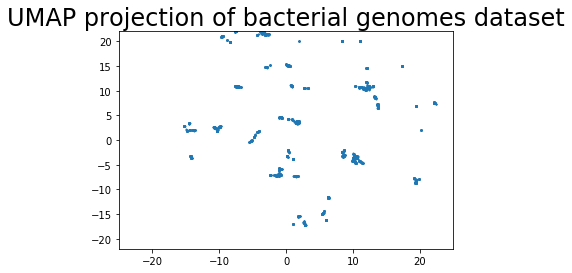

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns

#plt.scatter(*embedding.T, s = 1)
plt.scatter(embedding[:, 0], embedding[:, 1],  s = 1) #c=[sns.color_palette()[x] for x in Y])]
#plt.gca().set_aspect('equal', 'datalim')
axes = plt.gca()
axes.set_xlim([-25,25])
axes.set_ylim([-22,22])
plt.title('UMAP projection of bacterial genomes dataset', fontsize=24);

'''
Where a and b are assumed to be 2 points in the UMAP space

'''


Then, we cluster the data using HDBScan, using it to fit our embedding. The clusterer we get has labels for all 3867 genomes, ranging from cluster 0 to cluster 39 (with cluster -1 labeling data that was unable to be clustered). 

In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples = 40).fit(embedding)
print(clusterer.labels_.max())
print(clusterer.labels_)
print(clusterer.labels_.min())

From the cluster labels, we want to plot our reduced data while associating each point with its respective cluster, and evaluate its closeness to each data point sharing that cluster. We thus import umap.plot, a package using the interactive Bokeh plotting tool, and plot each genome in the embedding, with a different color according to the clusterer’s label of that genome. 

In [131]:
# See labels of UMAP projection
import umap.plot
#umap.plot.points(mapper)
umap.plot.output_notebook()

Loading BokehJS ...

Alongside the data point, we create hover data, consisting of the genome’s association, cluster number, taxonomy, and bray-curtis similarity (with reference being the first genome in the entire dataset).

In [47]:
print(type(site))
hover_data = pd.DataFrame({'distance':distance.to_numpy(), 'taxon': taxon.to_numpy(), 'site': site.to_numpy()})
print(hover_data)
#p = umap.plot.interactive(mapper,hover_data=hover_data, point_size=2)
#umap.plot.show(p)
hover_data['association'] = list(association)
hover_data['cluster'] = clusterer.labels_


<class 'pandas.core.series.Series'>
      distance                                              taxon     site
0          1.0  [Bacteroidetes, Bacteroidetes, Cytophagia, Cyt...  Unknown
1          0.0  [Alphaproteobacteria, Proteobacteria, Alphapro...  Unknown
2          0.0  [Alphaproteobacteria, Proteobacteria, Alphapro...  Unknown
3          0.0  [Burkholderiales, Proteobacteria, Betaproteoba...  Unknown
4          0.0  [Pseudomonas, Proteobacteria, Gammaproteobacte...  Unknown
...        ...                                                ...      ...
3832       0.0  [Alphaproteobacteria, Proteobacteria, Alphapro...  Cologne
3833       0.0  [Alphaproteobacteria, Proteobacteria, Alphapro...  Cologne
3834       0.0  [Alphaproteobacteria, Proteobacteria, Alphapro...  Cologne
3835       0.0  [Actinobacteria_one, Actinobacteria, Actinobac...  Cologne
3836       0.0  [Actinobacteria_one, Actinobacteria, Actinobac...  Cologne

[3837 rows x 3 columns]


Plot the clusters with the hover data. 

In [ ]:

print(hover_data.head())
p = umap.plot.interactive(mapper, labels = clusterer.labels_, color_key_cmap='Paired', background='black',hover_data=hover_data, point_size=15)
umap.plot.show(p)
# Colour palette for HDBScan Plot
#palette = sns.color_palette()
#color_palette = sns.color_palette('Paired', clusterer.labels_.max()+1)
#cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
#cluster_member_colors = [sns.desaturate(x, p) for x, p in
                        # zip(cluster_colors, clusterer.probabilities_)]
#plt.scatter(*embedding.T, s=5, linewidth=0, c=cluster_member_colors, alpha=0.25)


A manual check of the hover data for each cluster shows great taxonomic similarity both by bray-curtis similarity, as well as closeness in taxonomy (similarity down to the genus). 

In [244]:
'''
    Test to see which clusters match up to what taxonomy. Print statement is commented out to avoid clutter.
'''
for clusternum in range(0, clusterer.labels_.max()+1):
    print('Cluster: ', clusternum)
    for genome in range(len(hover_data)):
        if hover_data.iloc[genome, -1] == clusternum:
            #print(hover_data.iloc[genome, taxoncol])
            pass

Cluster:  0
Cluster:  1
Cluster:  2
Cluster:  3
Cluster:  4
Cluster:  5
Cluster:  6
Cluster:  7
Cluster:  8
Cluster:  9
Cluster:  10
Cluster:  11
Cluster:  12
Cluster:  13
Cluster:  14
Cluster:  15
Cluster:  16
Cluster:  17
Cluster:  18
Cluster:  19
Cluster:  20
Cluster:  21
Cluster:  22
Cluster:  23
Cluster:  24
Cluster:  25
Cluster:  26
Cluster:  27
Cluster:  28
Cluster:  29
Cluster:  30
Cluster:  31
Cluster:  32
Cluster:  33
Cluster:  34
Cluster:  35
Cluster:  36
Cluster:  37
Cluster:  38
Cluster:  39
Cluster:  40


It seems a good proportion of the data is clustered as well.

In [245]:
labels = hdbscan.HDBSCAN(
    min_samples=40,
    min_cluster_size=10,
).fit_predict(embedding)
print('Proportion of data clustered: ', np.sum(labels >= 0) / vdf.shape[0])

Proportion of data clustered:  0.9051342194422726


Having validated our clusters, we move on to isolate genes that are unique to each cluster. Using this approach, we can find families of genes that are specific to groups of bacteria and the symbiotic relationships they may have.

We first create an empty matrix indexed by association: “PA”, “NPA”, “soil”, for plant, non-plant, and soil-association bacteria respectively. Column names range from 0-39, being the cluster labels we have created. 

In [249]:
emptyrow = [[] for i in range(clusterer.labels_.max() + 2)]
gene_clusters = pd.DataFrame(data = [emptyrow for i in range(3)], index = ['PA', 'NPA', 'soil'], 
                             columns = list(range(clusterer.labels_.min(), clusterer.labels_.max()+1)))

Each cluster should have some NPA genes and PA genes:

Find unique clusters, find all genes of NPAS and all genes of PAs, find unique genes to each.

For each classification, get a list of the genes. Add to cluster under NPA or PA. 
Then, for each cluster, iterate through each NPA gene and check if it is a PA/soil gene. 
If it's unique to NPA, then add it to uniques.

Then, we loop through our cluster labels and select one by one possible genes of interest for each genome, by returning a list of all genes present in the genome. By parsing our matrix containing the metadata for the association of that genome, we obtain an index. Similarly, we set our column name to the cluster label. By grouping together all possible genes of interest by the cluster label, we can find genes unique to each cluster. But first, we turn all the genes of interest into a set, as we are not interested in duplicate genes. We thus annotate our empty matrix with all the genes of interest in a certain cluster, with a certain association.

In [250]:
# For each cluster label, equivalent to iterating through each genome
for cluster in range(len(clusterer.labels_)):
    # check for genes of interest
    row = vdf.iloc[cluster]
    genes_of_interest = list(row[row > 0].index)
    classification = association[cluster]
    total_genes = list(set(gene_clusters.at[classification,clusterer.labels_[cluster]] + genes_of_interest))
    gene_clusters.at[classification,clusterer.labels_[cluster]] = total_genes
print(gene_clusters)

TypeError: '>' not supported between instances of 'str' and 'int'

In [251]:
print(len(gene_clusters.iloc[0, 0]))

0


At this point, our matrix contains genes that are not unique to 1 cluster and 1 association. For example, COG 2468 is found in both cluster 2 and 38 (vastly different clusters), while COG 1833 is found only in cluster 4, but is found in both plant association, non-plant associated, and soil-associated bacteria. Since we are only interested in the plant-associated bacteria, it makes sense that our genes of interest would not be found in non-plant or soil-associated equivalents. As well, our genes of interest should be unique to one cluster, as ideally the symbiotic relationship should not be found in other clusters. 

Thus, we first remove the genes within a cluster that are found in multiple associations. We do this by looping through our matrix, and make a set of the differences between the plant associated genes and the soil and non-plant associated genes. This set comprises all the genes of plant-associated bacteria that would not be found in bacteria that are not plant associated. We repeat this to obtain genes unique to non-plant associated bacteria, as well as soil-associated bacteria.


In [ ]:
classifications = {0:"PA", 1:"NPA",  2:"soil"}

# check each cluster
for i in range(clusterer.labels_.max()+2):
    # for each classification
    for current_class in classifications.keys():
        ind = list(range(3))
        ind.pop(current_class)
        # See if gene is unique to PA, NPA, Soil, within current cluster
        unique = list(set(gene_clusters.iloc[current_class,i]) - set(gene_clusters.iloc[ind[0], i]) - set(gene_clusters.iloc[ind[1], i]))
        gene_clusters.loc[classifications[current_class] + ' unique', i-1] = unique
        #print(gene_clusters.at[j+3, clusterer.labels_[i]])
print(gene_clusters.iloc[:, 1:])  

We save all the unique genes into a new dataframe.

In [ ]:
S_U = gene_clusters.iloc[3, 1:]
PA_U = gene_clusters.iloc[4, 1:]
NPA_U = gene_clusters.iloc[5, 1:]

unique_genes = gene_clusters.iloc[3:, 1:]
unique_genes.to_csv('unique_genes_association.csv')

After transforming these sets into a Dataframe organized by association (index) and cluster number (column index), we iterate through all the clusters. For each cluster, we select genes unique to an association and compare those genes to all other genes in all other clusters. By taking their difference as a set, we ensure that our genes of interest are both unique to a cluster/taxonomy, and unique to an association.

In [ ]:
# test all the PAU in one cluster and make sure they arent in another cluster
copies_removed = S_U

for cluster in range(len(copies_removed)):
    all_genes_in_cluster = copies_removed.iloc[cluster]
    original_number_of_genes = len(all_genes_in_cluster)
    if (original_number_of_genes > 0):
        inds = list(range(len(copies_removed)))
        inds.pop(cluster)
        # iteratively remove duplicates that are found in other clusters
        for j in inds:
            all_genes_in_cluster= list(set(all_genes_in_cluster) - set(copies_removed.iloc[j]))
        #print(len(all_genes_in_cluster)/original_number_of_genes)
        copies_removed.iat[cluster] = all_genes_in_cluster
print(copies_removed)

In [185]:
#Comparison between new and old clusters, only for when .copy() is used since otherwise original df has been mutated
for cluster in range(len(copies_removed)):
    #print(len(copies_removed.iloc[cluster]), ' and ', len(S_U.iloc[cluster]))
    pass

In [237]:
for cluster in range(len(copies_removed)):
     if len(copies_removed.iloc[cluster]) > 0:
        #print('Cluster ', cluster, ' ', len(copies_removed.iloc[cluster]))
        #print(copies_removed.iloc[cluster])
        pass
# Peek at unique gene cluster dataframe
print(gene_clusters.head().iloc[:, 0:5])

                                                            -1  \
PA           [COG0014, COG3913, COG0851, COG3898, COG1587, ...   
NPA          [COG0014, COG3913, COG4481, COG0851, COG3898, ...   
soil         [COG0014, COG3913, COG4481, COG0851, COG3898, ...   
soil unique  [COG1887, COG3648, COG4940, COG2456, COG0615, ...   
PA unique        [COG5482, COG4130, COG4189, COG1306, COG5659]   

                                                             0  \
PA           [COG0014, COG4481, COG1587, COG1286, COG4838, ...   
NPA          [COG0014, COG4481, COG1587, COG1286, COG4838, ...   
soil         [COG0014, COG4481, COG1587, COG1286, COG4838, ...   
soil unique  [COG4588, COG1212, COG4536, COG4115, COG3586, ...   
PA unique    [COG2031, COG2170, COG3566, COG3012, COG3118, ...   

                                                             1  \
PA           [COG0014, COG3913, COG0851, COG1587, COG1218, ...   
NPA          [COG0014, COG3913, COG0851, COG1587, COG1218, ...   
soil    

In [252]:
print(unique_genes)
unique_genes.to_csv("UNQ2.csv")

                                                            0   \
soil unique  [COG4588, COG1212, COG4536, COG4115, COG3586, ...   
PA unique    [COG2031, COG2170, COG3566, COG3012, COG3118, ...   
NPA unique   [COG4483, COG4837, COG4477, COG3589, COG4851, ...   

                                                            1   \
soil unique  [COG0410, COG1288, COG3123, COG5449, COG4233, ...   
PA unique    [COG4521, COG5397, COG4259, COG3958, COG3575, ...   
NPA unique   [COG3130, COG3703, COG2905, COG4764, COG5501, ...   

                                                            2   \
soil unique  [COG3118, COG1169, COG3786, COG2717, COG1177, ...   
PA unique    [COG5511, COG3453, COG5437, COG3837, COG3639, ...   
NPA unique                                                  []   

                                                            3   \
soil unique  [COG4315, COG5605, COG5586, COG4237, COG4608, ...   
PA unique    [COG2933, COG4648, COG0851, COG3117, COG4255, ...   
NPA uni

Lastly, we transform our genes of interest into a Dataframe with 1 row for each gene, and summary statistics for its frequency.

Compute the breakdown.

In [ ]:
# Get breakdown of PA-NPA-soil ratio in each cluster, as well as cluster sizes
breakdown= pd.DataFrame(data = np.zeros([3,clusterer.labels_.max()+1]), index =["NPA", "PA", "soil"], 
                        columns = list(range(clusterer.labels_.max() + 1)))
clusternums = list(range(clusterer.labels_.max()+1))
cluster_sizes = {key: 0 for key in clusternums}

print(breakdown)
# for each genome
for i in range(len(clusterer.labels_)):
    # if the entry has been properly clustered
    if clusterer.labels_[i] != -1:
        assoc = 3
        # assign the breakdown for the respective association, and the respective cluster number
        breakdown.loc[hover_data.iloc[i, assoc], clusterer.labels_[i]] +=1
        cluster_sizes[clusterer.labels_[i]] +=1

Parse metadata to replace COG IDs with gene descriptors.

In [227]:
gene_description = {}

with open('cddid.tbl', 'r') as f:
    fs = f.readlines()
    for i in range(len(fs)):
        line = fs[i].split("\t")
        if 'COG' in line[1]:
            gene_description[line[1]] = line[3]

Initialize an empty dataframe and fill with summary statistics, computing the frequency by iterating through each cluster and classification.

In [2]:

table = pd.DataFrame(columns = ["COG ID", "COG ID Description", "Cluster number",
                                "Frequency/# times found in cluster", 
                                "# PA in cluster", "# NPA", "# soil", "classification", "cluster size"])

# Iterating through clusters 0-39
for cluster in range(clusterer.labels_.max()+1):
    for classification in unique_genes.index:
    # for each cluster-specific gene in the soil/pa/npa classification, append the class
        for i in range(len(unique_genes.loc[classification, cluster])):
            # get the key / descriptor for that gene + append to new table
            gene = UNQ.loc[classification, cluster][i]
            descr = 'N/A'
            try:
                descr = gene_description[gene]
            except Exception as e:
                pass
            gene_num = 0
            for l in range(len(vdf.columns)):
                if vdf.columns[l] == gene:
                    gene_num = l
                    break
            freq = sum([vdf.iloc[j, gene_num] for j in range(len(clusterer.labels_)) if clusterer.labels_[j] == cluster])
            entry = [gene, descr, cluster, freq,breakdown.at["PA",cluster],breakdown.at["NPA",cluster],
                     breakdown.at["soil", cluster], classification, cluster_sizes[cluster]]
            table.loc[gene] = entry
print(table.head())

NameError: name 'pd' is not defined

Finally, let's save the table as a CSV.

In [229]:
table.to_csv("singular_genes_by_association.csv") 


metagenomics samples that are revelant to the PA genes (the bins/reassembled genome that contain the genes)
1. find microbes that are PA
2. break down by metagenomics-do the binning, and then
3. look for distribution/enrichment of PA genes


Grow bacteria , extract DNA, 
Symbiotic rels of bacteria in dirt, 
Cant isolate the bugs in soil so just take all the DNA you can find, 
Bin together similar taxons, see what comes out, assembly and maximizes coverage

Are those PA genes being found in our genes? Using metagenomics as a type of validation
